In [3]:
import feature_extraction as fe

import numpy as np

import os
import random
import pickle
import warnings
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

seed = 3
random.seed(seed)
torch.manual_seed(seed)

warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
def data_batcher(data, batch_size):
    random.shuffle(data)
    return [data[i:i + batch_size] for i in range(0, len(data), batch_size)]

In [5]:
dataset = 'GTZAN'
new_feats = False


dataset_filename = f'../datasets/{dataset}.gui'
pickle_filename = f'./feats_spects-pickles/{dataset_filename.split("/")[-1][:-4]}_feats.pkl'

        
if new_feats or not os.path.isfile(pickle_filename):
    feats, labels = fe.extract_numfeats(dataset_filename)
    with open(pickle_filename, 'wb') as f:
        pickle.dump([feats, labels], f)
else:
    with open(pickle_filename, 'rb') as f:
        feats, labels = pickle.load(f)
    print(f'{feats.shape[0]} features extracted')

1000 features extracted


In [6]:
scaler = StandardScaler()
scaled_feats = scaler.fit_transform(feats)

x_trainval, x_test, y_trainval, y_test = train_test_split(scaled_feats, labels, test_size=1/10) # NO TOCAR!
x_train, x_val, y_train, y_val = train_test_split(x_trainval, y_trainval, test_size=1/9)        # NO TOCAR!

train_data = [(x, y) for x, y in zip(x_train, y_train)]
val_data = [(x, y) for x, y in zip(x_val, y_val)]
test_data = [(x, y) for x, y in zip(x_test, y_test)]

print(len(train_data), "training samples")
print(len(val_data), "validation samples")
print(len(test_data), "test samples")

800 training samples
100 validation samples
100 test samples


In [7]:
# Fully connected neural network with one hidden layer
class DNNClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, dropout):
        super(DNNClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size[0])
        self.fc2 = nn.Linear(hidden_size[0], hidden_size[1])
        self.fc3 = nn.Linear(hidden_size[1], hidden_size[2])
        self.fc4 = nn.Linear(hidden_size[2], hidden_size[3])
        self.fc5 = nn.Linear(hidden_size[3], num_classes)
        
        self.bn2 = nn.BatchNorm1d(hidden_size[1])
        self.bn3 = nn.BatchNorm1d(hidden_size[2])
        self.bn4 = nn.BatchNorm1d(hidden_size[3])
        
        self.drop_layer = nn.Dropout(p=dropout)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.drop_layer(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.drop_layer(x)
        x = F.relu(self.bn3(self.fc3(x)))
        x = self.drop_layer(x)
        x = F.relu(self.bn4(self.fc4(x)))
        x = self.fc5(x)
        return x # we can return here the softmax, but then we should use the nll_loss instead of the cross_entropy

In [8]:
def train(log_interval, model, device, data_batches, optimizer, epoch):
    losses = []
    len_glob_data = np.prod(np.array(np.array(data_batches).shape[:-1]))
    
    model.train()
    
    for i, batch in enumerate(data_batches):
        x, y = list(zip(*batch))
        
        # Move tensors to the configured device
        data = torch.from_numpy(np.array(x)).float().to(device)
        target = torch.from_numpy(np.array(y)).to(device)
        
        # clear all the gradients of the optimized tensors
        optimizer.zero_grad()
    
        # Forward pass
        output = model(data)
        loss = criterion(output, target)
        
        # Backward and optimize
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        
        if (i+1) % log_interval == 0:
            print(f'Train Epoch: {epoch+1} [{str((i+1)*len(data)).zfill((len(str(len_glob_data))))}/{len_glob_data} ({str(int(100. * (i+1)*len(data) / len_glob_data)).zfill(2)}%)]\tLoss: {round(loss.item(),6)}')
    return np.array(losses).mean()

In [9]:
def validate(model, device, data_batches):
    len_glob_data = np.prod(np.array(np.array(data_batches).shape[:-1]))
    
    model.eval()  # let's put the model in evaluation mode

    validation_loss = []
    correct = 0
    with torch.no_grad():  # we don't need gradient computation at all
        for i, batch in enumerate(data_batches):
            x, y = list(zip(*batch))
        
            data = torch.from_numpy(np.array(x)).float().to(device)
            target = torch.from_numpy(np.array(y)).to(device)
            
            output = model(data)
            loss = criterion(output, target)
            
            validation_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    validation_loss = np.array(validation_loss).mean()
    accuracy = 100. * correct / len_glob_data

    print(f'\nValidation set: Average loss: {round(validation_loss, 4)}, Accuracy: {correct}/{len_glob_data} ({int(accuracy)}%)\n')
    
    return accuracy, validation_loss

In [10]:
def test(model, device, data_batches):
    len_glob_data = np.prod(np.array(np.array(data_batches).shape[:-1]))
    
    model.eval()  # let's put the model in evaluation mode

    correct = 0
    with torch.no_grad():  # we don't need gradient computation at all
        for i, batch in enumerate(data_batches):
            x, y = list(zip(*batch))
        
            data = torch.from_numpy(np.array(x)).float().to(device)
            target = torch.from_numpy(np.array(y)).to(device)
            
            output = model(data)
            loss = criterion(output, target)
            
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    accuracy = 100. * correct / len_glob_data

    print(f'Test set: Accuracy: {correct}/{len_glob_data} ({int(accuracy)}%)\n')
    
    return accuracy

In [11]:
def plt_curves(train_losses, valid_losses, accuracies):
    fig = plt.figure()
    fig.subplots_adjust(right=2.5)

    ax1 = fig.add_subplot(121)
    ax1.set_title('Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.plot(train_losses, 'b-', label='Train')
    ax1.plot(valid_losses, 'r-', label='Validation')
    ax1.legend(loc='upper right')

    ax1 = fig.add_subplot(122)
    ax1.set_title('Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy (%)')
    ax1.plot(accuracies, 'b-')

    plt.show()

In [14]:
# Hyperparameters

input_size = 25
num_classes = 10

train_batch_size = 5 # NO TOCAR!
valid_batch_size = 100

hidden_size_list = [[256, 128, 64, 32], [512, 256, 128, 64], [128, 64, 32, 16]]
num_epochs = 100
learning_rate_list = [0.001, 0.0001, 0.00005]
dropout_list = [0.1, 0.25, 0.5]


------ NEW EXPERIMENT ------
Dropout = 0.1	Hidden Size = [256, 128, 64, 32]	Learning Rate = 0.001

Validation set: Average loss: 1.8988, Accuracy: 39/100 (39%)


Validation set: Average loss: 1.6663, Accuracy: 52/100 (52%)


Validation set: Average loss: 1.5317, Accuracy: 46/100 (46%)


Validation set: Average loss: 1.4292, Accuracy: 56/100 (56%)


Validation set: Average loss: 1.3721, Accuracy: 58/100 (58%)


Validation set: Average loss: 1.2905, Accuracy: 61/100 (61%)


Validation set: Average loss: 1.4057, Accuracy: 52/100 (52%)


Validation set: Average loss: 1.2765, Accuracy: 59/100 (59%)


Validation set: Average loss: 1.2034, Accuracy: 62/100 (62%)


Validation set: Average loss: 1.2009, Accuracy: 61/100 (61%)


Validation set: Average loss: 1.1867, Accuracy: 60/100 (60%)


Validation set: Average loss: 1.2876, Accuracy: 59/100 (59%)


Validation set: Average loss: 1.257, Accuracy: 62/100 (62%)


Validation set: Average loss: 1.1667, Accuracy: 62/100 (62%)


Validation set: Ave

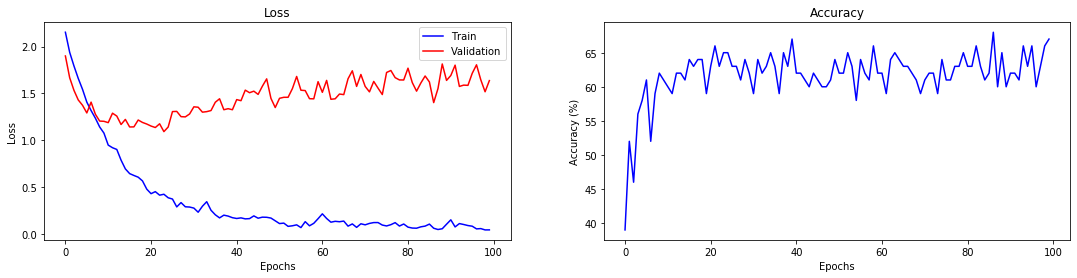


------ NEW EXPERIMENT ------
Dropout = 0.25	Hidden Size = [256, 128, 64, 32]	Learning Rate = 0.001

Validation set: Average loss: 1.9739, Accuracy: 37/100 (37%)


Validation set: Average loss: 1.7673, Accuracy: 44/100 (44%)


Validation set: Average loss: 1.6658, Accuracy: 47/100 (47%)


Validation set: Average loss: 1.5296, Accuracy: 52/100 (52%)


Validation set: Average loss: 1.4545, Accuracy: 54/100 (54%)


Validation set: Average loss: 1.3927, Accuracy: 55/100 (55%)


Validation set: Average loss: 1.3113, Accuracy: 56/100 (56%)


Validation set: Average loss: 1.277, Accuracy: 56/100 (56%)


Validation set: Average loss: 1.2296, Accuracy: 63/100 (63%)


Validation set: Average loss: 1.2405, Accuracy: 61/100 (61%)


Validation set: Average loss: 1.1796, Accuracy: 65/100 (65%)


Validation set: Average loss: 1.1524, Accuracy: 61/100 (61%)


Validation set: Average loss: 1.1731, Accuracy: 63/100 (63%)


Validation set: Average loss: 1.1519, Accuracy: 62/100 (62%)


Validation set: Av

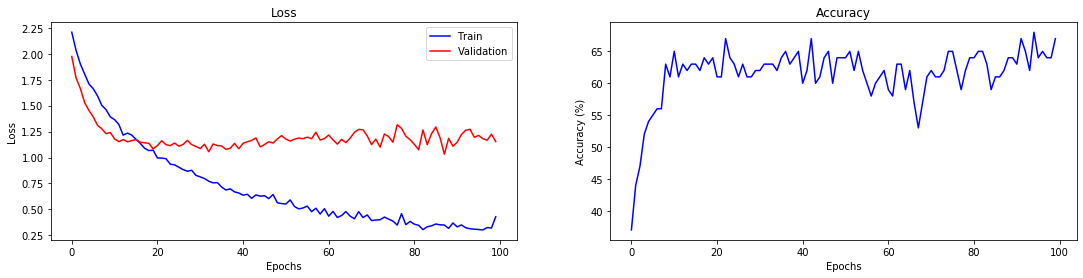


------ NEW EXPERIMENT ------
Dropout = 0.5	Hidden Size = [256, 128, 64, 32]	Learning Rate = 0.001

Validation set: Average loss: 2.169, Accuracy: 35/100 (35%)


Validation set: Average loss: 2.0155, Accuracy: 35/100 (35%)


Validation set: Average loss: 1.8779, Accuracy: 37/100 (37%)


Validation set: Average loss: 1.7752, Accuracy: 37/100 (37%)


Validation set: Average loss: 1.6856, Accuracy: 41/100 (41%)


Validation set: Average loss: 1.6488, Accuracy: 42/100 (42%)


Validation set: Average loss: 1.5718, Accuracy: 47/100 (47%)


Validation set: Average loss: 1.5479, Accuracy: 52/100 (52%)


Validation set: Average loss: 1.4935, Accuracy: 56/100 (56%)


Validation set: Average loss: 1.4953, Accuracy: 56/100 (56%)


Validation set: Average loss: 1.47, Accuracy: 54/100 (54%)


Validation set: Average loss: 1.4561, Accuracy: 48/100 (48%)


Validation set: Average loss: 1.4468, Accuracy: 57/100 (57%)


Validation set: Average loss: 1.4064, Accuracy: 58/100 (58%)


Validation set: Avera

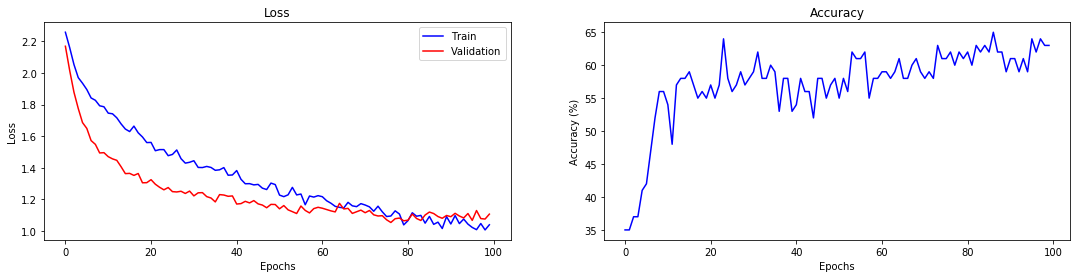


------ NEW EXPERIMENT ------
Dropout = 0.1	Hidden Size = [256, 128, 64, 32]	Learning Rate = 0.0001

Validation set: Average loss: 2.2373, Accuracy: 18/100 (18%)


Validation set: Average loss: 2.1807, Accuracy: 27/100 (27%)


Validation set: Average loss: 2.1517, Accuracy: 34/100 (34%)


Validation set: Average loss: 2.126, Accuracy: 36/100 (36%)


Validation set: Average loss: 2.0868, Accuracy: 45/100 (45%)


Validation set: Average loss: 2.057, Accuracy: 42/100 (42%)


Validation set: Average loss: 2.0181, Accuracy: 47/100 (47%)


Validation set: Average loss: 1.9962, Accuracy: 46/100 (46%)


Validation set: Average loss: 1.9599, Accuracy: 53/100 (53%)


Validation set: Average loss: 1.9202, Accuracy: 56/100 (56%)


Validation set: Average loss: 1.8968, Accuracy: 55/100 (55%)


Validation set: Average loss: 1.859, Accuracy: 55/100 (55%)


Validation set: Average loss: 1.8214, Accuracy: 52/100 (52%)


Validation set: Average loss: 1.7818, Accuracy: 54/100 (54%)


Validation set: Aver

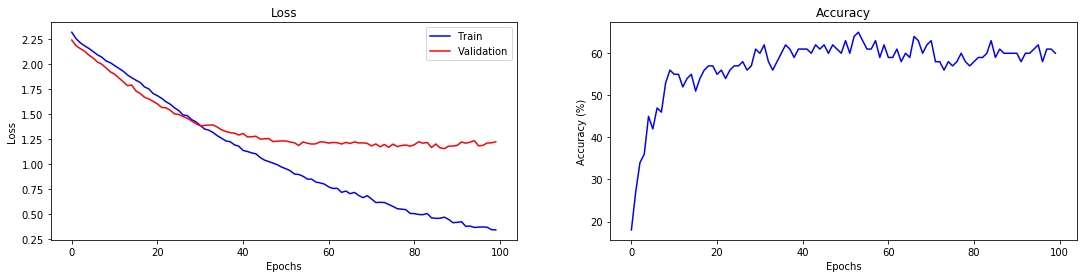


------ NEW EXPERIMENT ------
Dropout = 0.25	Hidden Size = [256, 128, 64, 32]	Learning Rate = 0.0001

Validation set: Average loss: 2.298, Accuracy: 11/100 (11%)


Validation set: Average loss: 2.2401, Accuracy: 20/100 (20%)


Validation set: Average loss: 2.1796, Accuracy: 25/100 (25%)


Validation set: Average loss: 2.1379, Accuracy: 30/100 (30%)


Validation set: Average loss: 2.0936, Accuracy: 33/100 (33%)


Validation set: Average loss: 2.0476, Accuracy: 35/100 (35%)


Validation set: Average loss: 2.0321, Accuracy: 42/100 (42%)


Validation set: Average loss: 1.9823, Accuracy: 44/100 (44%)


Validation set: Average loss: 1.9484, Accuracy: 45/100 (45%)


Validation set: Average loss: 1.9157, Accuracy: 42/100 (42%)


Validation set: Average loss: 1.888, Accuracy: 42/100 (42%)


Validation set: Average loss: 1.8784, Accuracy: 41/100 (41%)


Validation set: Average loss: 1.8296, Accuracy: 46/100 (46%)


Validation set: Average loss: 1.7989, Accuracy: 44/100 (44%)


Validation set: Av

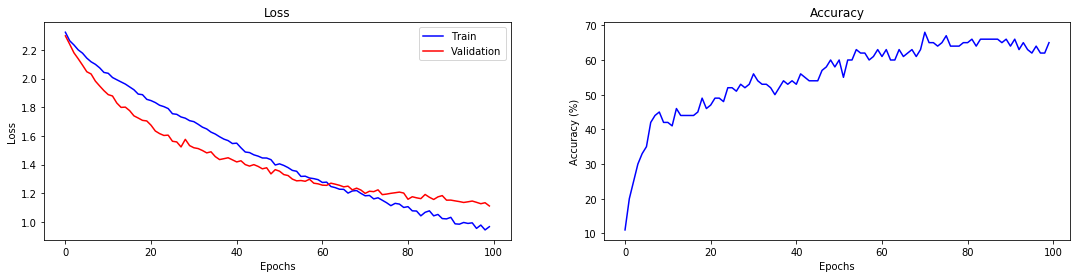


------ NEW EXPERIMENT ------
Dropout = 0.5	Hidden Size = [256, 128, 64, 32]	Learning Rate = 0.0001

Validation set: Average loss: 2.2711, Accuracy: 22/100 (22%)


Validation set: Average loss: 2.2696, Accuracy: 25/100 (25%)


Validation set: Average loss: 2.2538, Accuracy: 29/100 (29%)


Validation set: Average loss: 2.2355, Accuracy: 28/100 (28%)


Validation set: Average loss: 2.2158, Accuracy: 33/100 (33%)


Validation set: Average loss: 2.2102, Accuracy: 31/100 (31%)


Validation set: Average loss: 2.1922, Accuracy: 32/100 (32%)


Validation set: Average loss: 2.1937, Accuracy: 34/100 (34%)


Validation set: Average loss: 2.1629, Accuracy: 37/100 (37%)


Validation set: Average loss: 2.1465, Accuracy: 39/100 (39%)


Validation set: Average loss: 2.1288, Accuracy: 41/100 (41%)


Validation set: Average loss: 2.1139, Accuracy: 40/100 (40%)


Validation set: Average loss: 2.1022, Accuracy: 41/100 (41%)


Validation set: Average loss: 2.0958, Accuracy: 40/100 (40%)


Validation set: A

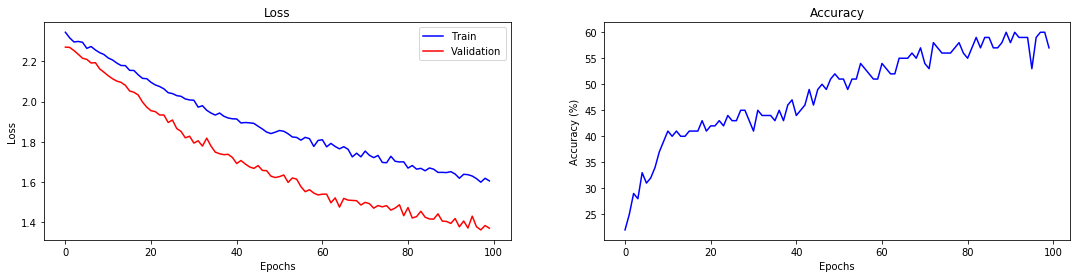


------ NEW EXPERIMENT ------
Dropout = 0.1	Hidden Size = [256, 128, 64, 32]	Learning Rate = 5e-05

Validation set: Average loss: 2.2117, Accuracy: 27/100 (27%)


Validation set: Average loss: 2.1639, Accuracy: 36/100 (36%)


Validation set: Average loss: 2.1251, Accuracy: 39/100 (39%)


Validation set: Average loss: 2.088, Accuracy: 42/100 (42%)


Validation set: Average loss: 2.0645, Accuracy: 43/100 (43%)


Validation set: Average loss: 2.0359, Accuracy: 45/100 (45%)


Validation set: Average loss: 2.0065, Accuracy: 46/100 (46%)


Validation set: Average loss: 1.9852, Accuracy: 46/100 (46%)


Validation set: Average loss: 1.9687, Accuracy: 47/100 (47%)


Validation set: Average loss: 1.9528, Accuracy: 47/100 (47%)


Validation set: Average loss: 1.9185, Accuracy: 47/100 (47%)


Validation set: Average loss: 1.9008, Accuracy: 47/100 (47%)


Validation set: Average loss: 1.8765, Accuracy: 50/100 (50%)


Validation set: Average loss: 1.8625, Accuracy: 49/100 (49%)


Validation set: Ave

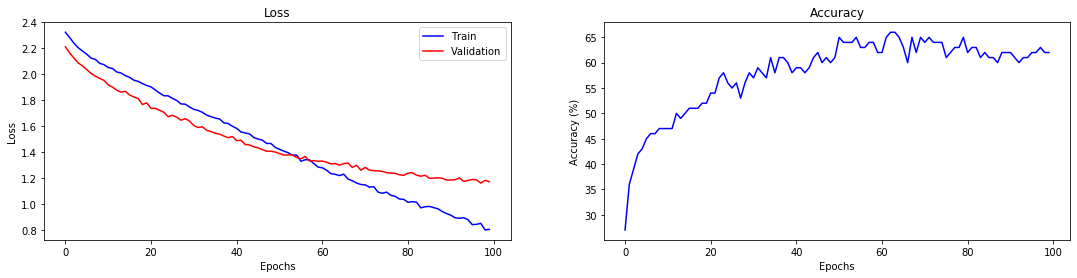


------ NEW EXPERIMENT ------
Dropout = 0.25	Hidden Size = [256, 128, 64, 32]	Learning Rate = 5e-05

Validation set: Average loss: 2.2999, Accuracy: 10/100 (10%)


Validation set: Average loss: 2.2847, Accuracy: 10/100 (10%)


Validation set: Average loss: 2.2561, Accuracy: 12/100 (12%)


Validation set: Average loss: 2.2384, Accuracy: 17/100 (17%)


Validation set: Average loss: 2.2218, Accuracy: 23/100 (23%)


Validation set: Average loss: 2.2035, Accuracy: 28/100 (28%)


Validation set: Average loss: 2.1951, Accuracy: 25/100 (25%)


Validation set: Average loss: 2.1769, Accuracy: 29/100 (29%)


Validation set: Average loss: 2.1673, Accuracy: 32/100 (32%)


Validation set: Average loss: 2.1509, Accuracy: 30/100 (30%)


Validation set: Average loss: 2.1413, Accuracy: 30/100 (30%)


Validation set: Average loss: 2.1154, Accuracy: 35/100 (35%)


Validation set: Average loss: 2.1119, Accuracy: 34/100 (34%)


Validation set: Average loss: 2.1058, Accuracy: 36/100 (36%)


Validation set: A

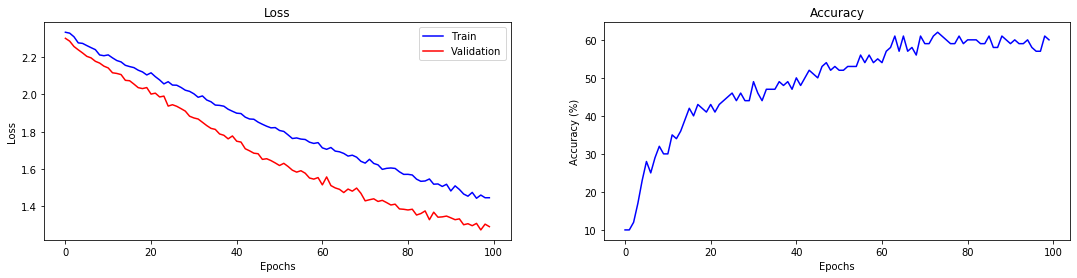


------ NEW EXPERIMENT ------
Dropout = 0.5	Hidden Size = [256, 128, 64, 32]	Learning Rate = 5e-05

Validation set: Average loss: 2.3038, Accuracy: 9/100 (9%)


Validation set: Average loss: 2.2971, Accuracy: 10/100 (10%)


Validation set: Average loss: 2.283, Accuracy: 14/100 (14%)


Validation set: Average loss: 2.2763, Accuracy: 15/100 (15%)


Validation set: Average loss: 2.2734, Accuracy: 14/100 (14%)


Validation set: Average loss: 2.2699, Accuracy: 15/100 (15%)


Validation set: Average loss: 2.2535, Accuracy: 15/100 (15%)


Validation set: Average loss: 2.2543, Accuracy: 22/100 (22%)


Validation set: Average loss: 2.24, Accuracy: 18/100 (18%)


Validation set: Average loss: 2.2282, Accuracy: 24/100 (24%)


Validation set: Average loss: 2.2253, Accuracy: 25/100 (25%)


Validation set: Average loss: 2.2129, Accuracy: 30/100 (30%)


Validation set: Average loss: 2.2102, Accuracy: 28/100 (28%)


Validation set: Average loss: 2.1972, Accuracy: 26/100 (26%)


Validation set: Average

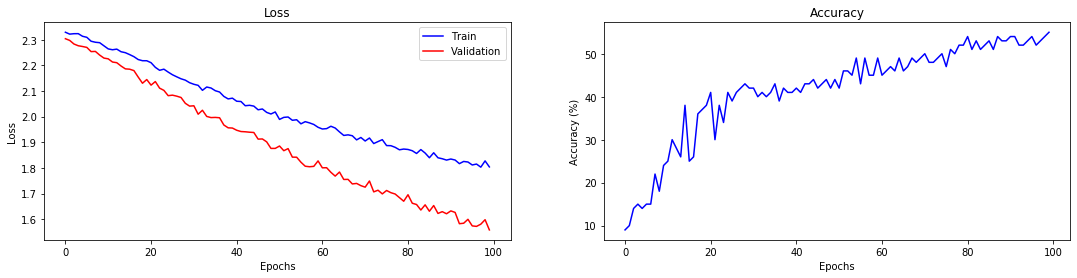


------ NEW EXPERIMENT ------
Dropout = 0.1	Hidden Size = [512, 256, 128, 64]	Learning Rate = 0.001

Validation set: Average loss: 1.6846, Accuracy: 55/100 (55%)


Validation set: Average loss: 1.4566, Accuracy: 57/100 (57%)


Validation set: Average loss: 1.3498, Accuracy: 58/100 (58%)


Validation set: Average loss: 1.314, Accuracy: 56/100 (56%)


Validation set: Average loss: 1.1784, Accuracy: 60/100 (60%)


Validation set: Average loss: 1.1972, Accuracy: 58/100 (58%)


Validation set: Average loss: 1.0673, Accuracy: 63/100 (63%)


Validation set: Average loss: 1.1082, Accuracy: 59/100 (59%)


Validation set: Average loss: 1.1508, Accuracy: 63/100 (63%)


Validation set: Average loss: 1.1298, Accuracy: 61/100 (61%)


Validation set: Average loss: 1.1564, Accuracy: 57/100 (57%)


Validation set: Average loss: 1.0875, Accuracy: 62/100 (62%)


Validation set: Average loss: 1.1409, Accuracy: 61/100 (61%)


Validation set: Average loss: 1.1407, Accuracy: 58/100 (58%)


Validation set: Av

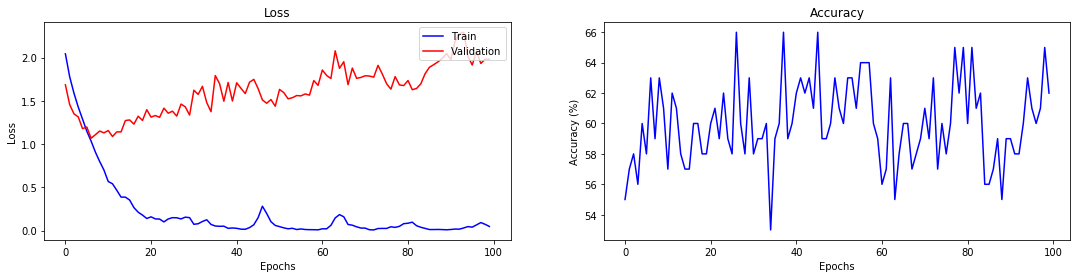


------ NEW EXPERIMENT ------
Dropout = 0.25	Hidden Size = [512, 256, 128, 64]	Learning Rate = 0.001

Validation set: Average loss: 1.7957, Accuracy: 44/100 (44%)


Validation set: Average loss: 1.5554, Accuracy: 52/100 (52%)


Validation set: Average loss: 1.4589, Accuracy: 56/100 (56%)


Validation set: Average loss: 1.3508, Accuracy: 59/100 (59%)


Validation set: Average loss: 1.3341, Accuracy: 57/100 (57%)


Validation set: Average loss: 1.2772, Accuracy: 59/100 (59%)


Validation set: Average loss: 1.2247, Accuracy: 57/100 (57%)


Validation set: Average loss: 1.1919, Accuracy: 59/100 (59%)


Validation set: Average loss: 1.1828, Accuracy: 63/100 (63%)


Validation set: Average loss: 1.1301, Accuracy: 60/100 (60%)


Validation set: Average loss: 1.1327, Accuracy: 63/100 (63%)


Validation set: Average loss: 1.1996, Accuracy: 60/100 (60%)


Validation set: Average loss: 1.1419, Accuracy: 60/100 (60%)


Validation set: Average loss: 1.1625, Accuracy: 64/100 (64%)


Validation set: 

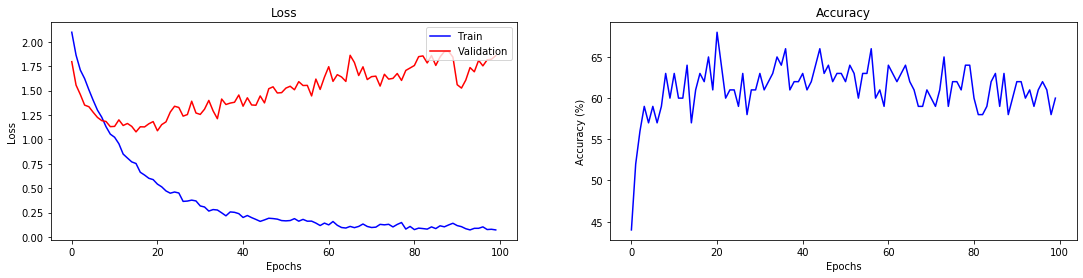


------ NEW EXPERIMENT ------
Dropout = 0.5	Hidden Size = [512, 256, 128, 64]	Learning Rate = 0.001

Validation set: Average loss: 1.9337, Accuracy: 40/100 (40%)


Validation set: Average loss: 1.6965, Accuracy: 44/100 (44%)


Validation set: Average loss: 1.5878, Accuracy: 52/100 (52%)


Validation set: Average loss: 1.522, Accuracy: 55/100 (55%)


Validation set: Average loss: 1.3998, Accuracy: 56/100 (56%)


Validation set: Average loss: 1.357, Accuracy: 55/100 (55%)


Validation set: Average loss: 1.358, Accuracy: 54/100 (54%)


Validation set: Average loss: 1.3212, Accuracy: 54/100 (54%)


Validation set: Average loss: 1.3142, Accuracy: 57/100 (57%)


Validation set: Average loss: 1.2744, Accuracy: 52/100 (52%)


Validation set: Average loss: 1.2657, Accuracy: 55/100 (55%)


Validation set: Average loss: 1.2331, Accuracy: 57/100 (57%)


Validation set: Average loss: 1.2314, Accuracy: 56/100 (56%)


Validation set: Average loss: 1.223, Accuracy: 57/100 (57%)


Validation set: Avera

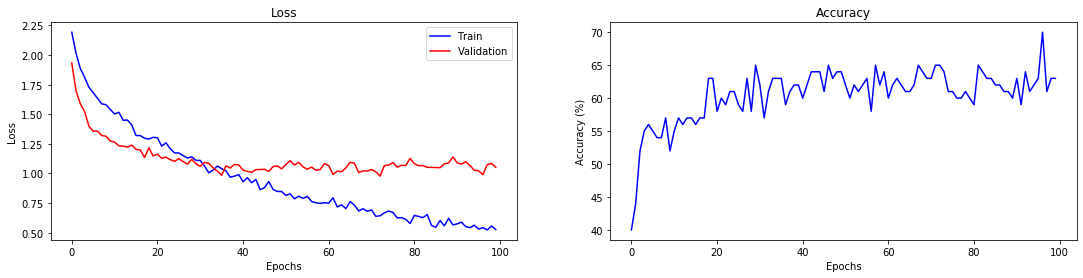


------ NEW EXPERIMENT ------
Dropout = 0.1	Hidden Size = [512, 256, 128, 64]	Learning Rate = 0.0001

Validation set: Average loss: 2.1127, Accuracy: 29/100 (29%)


Validation set: Average loss: 1.9909, Accuracy: 39/100 (39%)


Validation set: Average loss: 1.92, Accuracy: 42/100 (42%)


Validation set: Average loss: 1.841, Accuracy: 43/100 (43%)


Validation set: Average loss: 1.7741, Accuracy: 44/100 (44%)


Validation set: Average loss: 1.7223, Accuracy: 50/100 (50%)


Validation set: Average loss: 1.6833, Accuracy: 48/100 (48%)


Validation set: Average loss: 1.6244, Accuracy: 50/100 (50%)


Validation set: Average loss: 1.6202, Accuracy: 51/100 (51%)


Validation set: Average loss: 1.5667, Accuracy: 53/100 (53%)


Validation set: Average loss: 1.5284, Accuracy: 55/100 (55%)


Validation set: Average loss: 1.5261, Accuracy: 54/100 (54%)


Validation set: Average loss: 1.4864, Accuracy: 55/100 (55%)


Validation set: Average loss: 1.4551, Accuracy: 55/100 (55%)


Validation set: Ave

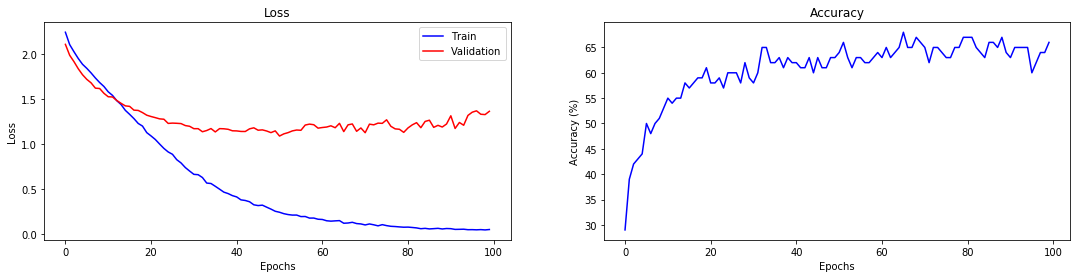


------ NEW EXPERIMENT ------
Dropout = 0.25	Hidden Size = [512, 256, 128, 64]	Learning Rate = 0.0001

Validation set: Average loss: 2.2284, Accuracy: 21/100 (21%)


Validation set: Average loss: 2.1361, Accuracy: 29/100 (29%)


Validation set: Average loss: 2.0706, Accuracy: 30/100 (30%)


Validation set: Average loss: 2.0094, Accuracy: 41/100 (41%)


Validation set: Average loss: 1.9515, Accuracy: 44/100 (44%)


Validation set: Average loss: 1.8993, Accuracy: 45/100 (45%)


Validation set: Average loss: 1.8376, Accuracy: 49/100 (49%)


Validation set: Average loss: 1.7906, Accuracy: 51/100 (51%)


Validation set: Average loss: 1.7567, Accuracy: 50/100 (50%)


Validation set: Average loss: 1.7315, Accuracy: 53/100 (53%)


Validation set: Average loss: 1.68, Accuracy: 53/100 (53%)


Validation set: Average loss: 1.6491, Accuracy: 53/100 (53%)


Validation set: Average loss: 1.6101, Accuracy: 54/100 (54%)


Validation set: Average loss: 1.5797, Accuracy: 55/100 (55%)


Validation set: A

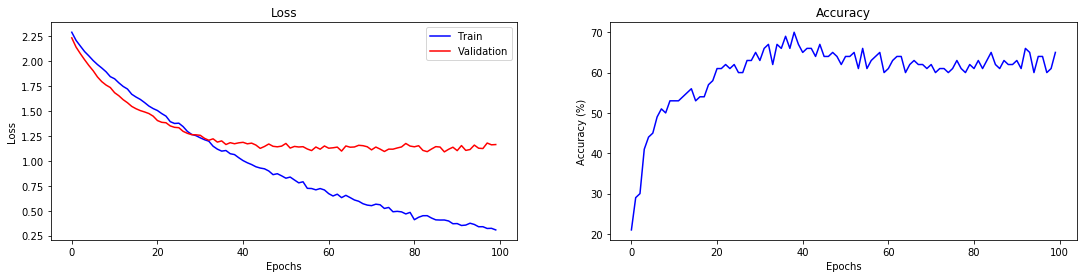


------ NEW EXPERIMENT ------
Dropout = 0.5	Hidden Size = [512, 256, 128, 64]	Learning Rate = 0.0001

Validation set: Average loss: 2.2787, Accuracy: 11/100 (11%)


Validation set: Average loss: 2.2491, Accuracy: 21/100 (21%)


Validation set: Average loss: 2.2168, Accuracy: 33/100 (33%)


Validation set: Average loss: 2.1967, Accuracy: 36/100 (36%)


Validation set: Average loss: 2.1591, Accuracy: 38/100 (38%)


Validation set: Average loss: 2.1372, Accuracy: 40/100 (40%)


Validation set: Average loss: 2.0765, Accuracy: 44/100 (44%)


Validation set: Average loss: 2.041, Accuracy: 45/100 (45%)


Validation set: Average loss: 2.0067, Accuracy: 47/100 (47%)


Validation set: Average loss: 1.975, Accuracy: 44/100 (44%)


Validation set: Average loss: 1.9249, Accuracy: 47/100 (47%)


Validation set: Average loss: 1.9118, Accuracy: 45/100 (45%)


Validation set: Average loss: 1.8734, Accuracy: 45/100 (45%)


Validation set: Average loss: 1.86, Accuracy: 45/100 (45%)


Validation set: Aver

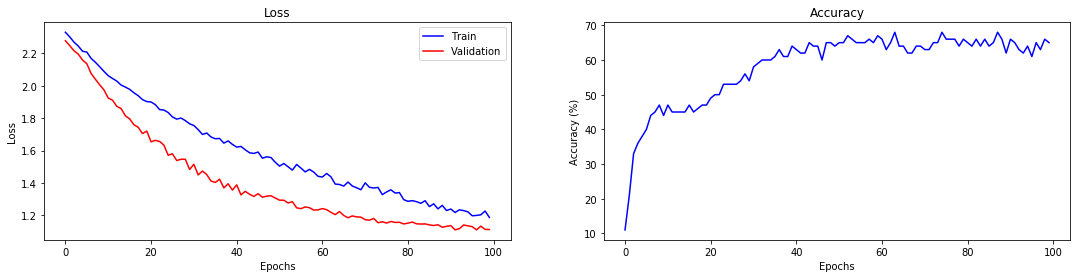


------ NEW EXPERIMENT ------
Dropout = 0.1	Hidden Size = [512, 256, 128, 64]	Learning Rate = 5e-05

Validation set: Average loss: 2.1597, Accuracy: 29/100 (29%)


Validation set: Average loss: 2.0798, Accuracy: 41/100 (41%)


Validation set: Average loss: 2.0259, Accuracy: 41/100 (41%)


Validation set: Average loss: 1.9865, Accuracy: 45/100 (45%)


Validation set: Average loss: 1.9418, Accuracy: 52/100 (52%)


Validation set: Average loss: 1.8908, Accuracy: 50/100 (50%)


Validation set: Average loss: 1.8816, Accuracy: 51/100 (51%)


Validation set: Average loss: 1.855, Accuracy: 53/100 (53%)


Validation set: Average loss: 1.8198, Accuracy: 53/100 (53%)


Validation set: Average loss: 1.8007, Accuracy: 52/100 (52%)


Validation set: Average loss: 1.7756, Accuracy: 54/100 (54%)


Validation set: Average loss: 1.76, Accuracy: 52/100 (52%)


Validation set: Average loss: 1.7346, Accuracy: 52/100 (52%)


Validation set: Average loss: 1.7078, Accuracy: 51/100 (51%)


Validation set: Aver

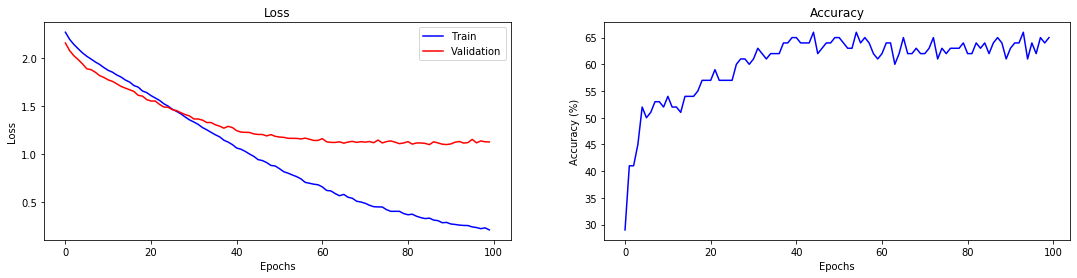


------ NEW EXPERIMENT ------
Dropout = 0.25	Hidden Size = [512, 256, 128, 64]	Learning Rate = 5e-05

Validation set: Average loss: 2.223, Accuracy: 29/100 (29%)


Validation set: Average loss: 2.1609, Accuracy: 41/100 (41%)


Validation set: Average loss: 2.1028, Accuracy: 42/100 (42%)


Validation set: Average loss: 2.0757, Accuracy: 39/100 (39%)


Validation set: Average loss: 2.0276, Accuracy: 44/100 (44%)


Validation set: Average loss: 2.0046, Accuracy: 45/100 (45%)


Validation set: Average loss: 1.9566, Accuracy: 44/100 (44%)


Validation set: Average loss: 1.9411, Accuracy: 45/100 (45%)


Validation set: Average loss: 1.9244, Accuracy: 49/100 (49%)


Validation set: Average loss: 1.8861, Accuracy: 47/100 (47%)


Validation set: Average loss: 1.87, Accuracy: 46/100 (46%)


Validation set: Average loss: 1.8293, Accuracy: 48/100 (48%)


Validation set: Average loss: 1.8156, Accuracy: 48/100 (48%)


Validation set: Average loss: 1.7885, Accuracy: 47/100 (47%)


Validation set: Ave

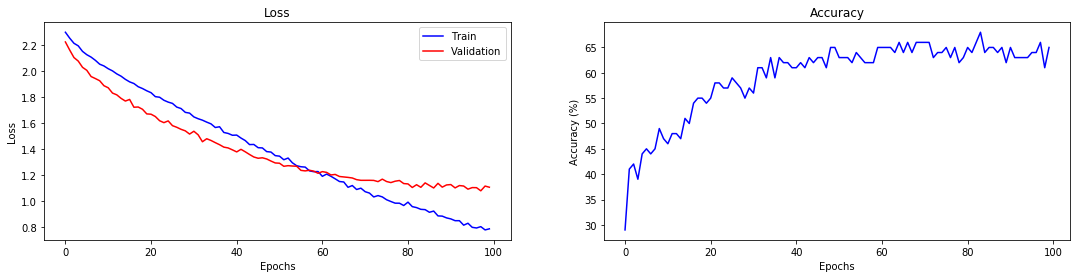


------ NEW EXPERIMENT ------
Dropout = 0.5	Hidden Size = [512, 256, 128, 64]	Learning Rate = 5e-05

Validation set: Average loss: 2.2845, Accuracy: 15/100 (15%)


Validation set: Average loss: 2.2601, Accuracy: 25/100 (25%)


Validation set: Average loss: 2.2443, Accuracy: 28/100 (28%)


Validation set: Average loss: 2.22, Accuracy: 35/100 (35%)


Validation set: Average loss: 2.2045, Accuracy: 39/100 (39%)


Validation set: Average loss: 2.1942, Accuracy: 38/100 (38%)


Validation set: Average loss: 2.1769, Accuracy: 39/100 (39%)


Validation set: Average loss: 2.1633, Accuracy: 40/100 (40%)


Validation set: Average loss: 2.1443, Accuracy: 38/100 (38%)


Validation set: Average loss: 2.1331, Accuracy: 44/100 (44%)


Validation set: Average loss: 2.1098, Accuracy: 45/100 (45%)


Validation set: Average loss: 2.0885, Accuracy: 40/100 (40%)


Validation set: Average loss: 2.0725, Accuracy: 43/100 (43%)


Validation set: Average loss: 2.0651, Accuracy: 41/100 (41%)


Validation set: Ave

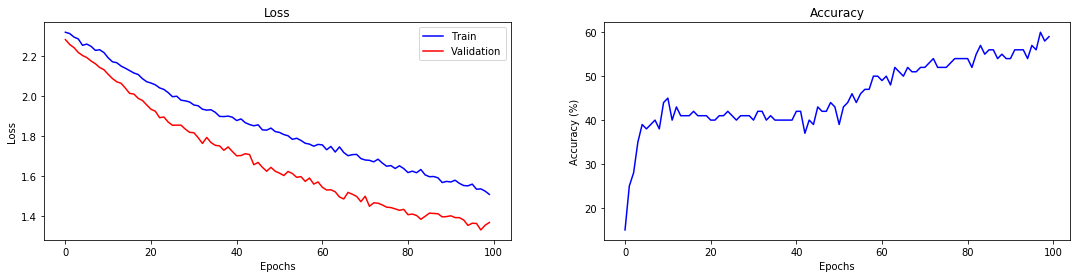


------ NEW EXPERIMENT ------
Dropout = 0.1	Hidden Size = [128, 64, 32, 16]	Learning Rate = 0.001

Validation set: Average loss: 2.1416, Accuracy: 33/100 (33%)


Validation set: Average loss: 1.9577, Accuracy: 43/100 (43%)


Validation set: Average loss: 1.7808, Accuracy: 48/100 (48%)


Validation set: Average loss: 1.6434, Accuracy: 50/100 (50%)


Validation set: Average loss: 1.5673, Accuracy: 51/100 (51%)


Validation set: Average loss: 1.4479, Accuracy: 54/100 (54%)


Validation set: Average loss: 1.4561, Accuracy: 53/100 (53%)


Validation set: Average loss: 1.3422, Accuracy: 50/100 (50%)


Validation set: Average loss: 1.2994, Accuracy: 53/100 (53%)


Validation set: Average loss: 1.327, Accuracy: 52/100 (52%)


Validation set: Average loss: 1.3016, Accuracy: 56/100 (56%)


Validation set: Average loss: 1.2911, Accuracy: 57/100 (57%)


Validation set: Average loss: 1.2045, Accuracy: 56/100 (56%)


Validation set: Average loss: 1.2774, Accuracy: 61/100 (61%)


Validation set: Aver

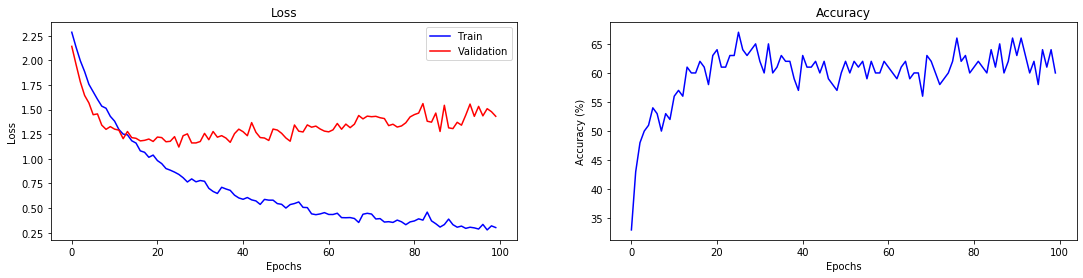


------ NEW EXPERIMENT ------
Dropout = 0.25	Hidden Size = [128, 64, 32, 16]	Learning Rate = 0.001

Validation set: Average loss: 2.2252, Accuracy: 18/100 (18%)


Validation set: Average loss: 2.0854, Accuracy: 18/100 (18%)


Validation set: Average loss: 1.9906, Accuracy: 26/100 (26%)


Validation set: Average loss: 1.8781, Accuracy: 41/100 (41%)


Validation set: Average loss: 1.7958, Accuracy: 41/100 (41%)


Validation set: Average loss: 1.7069, Accuracy: 41/100 (41%)


Validation set: Average loss: 1.5957, Accuracy: 46/100 (46%)


Validation set: Average loss: 1.6011, Accuracy: 44/100 (44%)


Validation set: Average loss: 1.4856, Accuracy: 51/100 (51%)


Validation set: Average loss: 1.4557, Accuracy: 53/100 (53%)


Validation set: Average loss: 1.4292, Accuracy: 56/100 (56%)


Validation set: Average loss: 1.4022, Accuracy: 51/100 (51%)


Validation set: Average loss: 1.3592, Accuracy: 53/100 (53%)


Validation set: Average loss: 1.3487, Accuracy: 54/100 (54%)


Validation set: Av

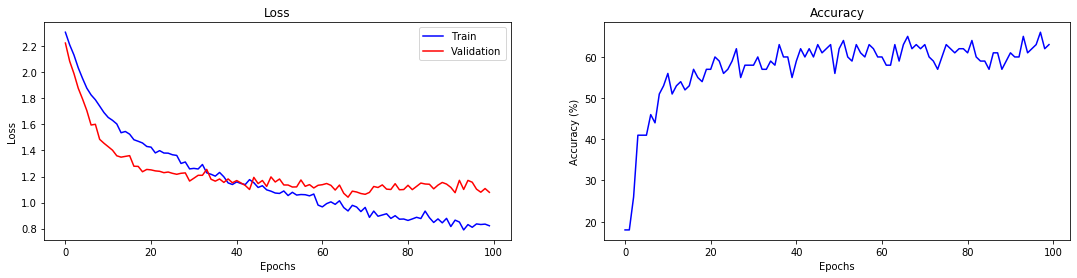


------ NEW EXPERIMENT ------
Dropout = 0.5	Hidden Size = [128, 64, 32, 16]	Learning Rate = 0.001

Validation set: Average loss: 2.2606, Accuracy: 13/100 (13%)


Validation set: Average loss: 2.2048, Accuracy: 31/100 (31%)


Validation set: Average loss: 2.1284, Accuracy: 30/100 (30%)


Validation set: Average loss: 2.0229, Accuracy: 40/100 (40%)


Validation set: Average loss: 1.952, Accuracy: 37/100 (37%)


Validation set: Average loss: 1.852, Accuracy: 39/100 (39%)


Validation set: Average loss: 1.7843, Accuracy: 38/100 (38%)


Validation set: Average loss: 1.7538, Accuracy: 45/100 (45%)


Validation set: Average loss: 1.7091, Accuracy: 46/100 (46%)


Validation set: Average loss: 1.6522, Accuracy: 47/100 (47%)


Validation set: Average loss: 1.6313, Accuracy: 49/100 (49%)


Validation set: Average loss: 1.6234, Accuracy: 51/100 (51%)


Validation set: Average loss: 1.5998, Accuracy: 51/100 (51%)


Validation set: Average loss: 1.5562, Accuracy: 51/100 (51%)


Validation set: Avera

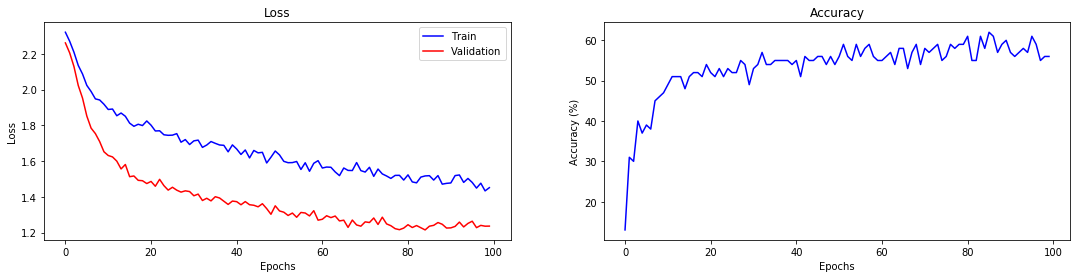


------ NEW EXPERIMENT ------
Dropout = 0.1	Hidden Size = [128, 64, 32, 16]	Learning Rate = 0.0001

Validation set: Average loss: 2.2724, Accuracy: 16/100 (16%)


Validation set: Average loss: 2.1921, Accuracy: 24/100 (24%)


Validation set: Average loss: 2.1586, Accuracy: 33/100 (33%)


Validation set: Average loss: 2.1178, Accuracy: 45/100 (45%)


Validation set: Average loss: 2.1074, Accuracy: 44/100 (44%)


Validation set: Average loss: 2.0798, Accuracy: 42/100 (42%)


Validation set: Average loss: 2.057, Accuracy: 41/100 (41%)


Validation set: Average loss: 2.0388, Accuracy: 42/100 (42%)


Validation set: Average loss: 2.0165, Accuracy: 43/100 (43%)


Validation set: Average loss: 1.983, Accuracy: 44/100 (44%)


Validation set: Average loss: 1.967, Accuracy: 45/100 (45%)


Validation set: Average loss: 1.9426, Accuracy: 44/100 (44%)


Validation set: Average loss: 1.9405, Accuracy: 44/100 (44%)


Validation set: Average loss: 1.9035, Accuracy: 44/100 (44%)


Validation set: Avera

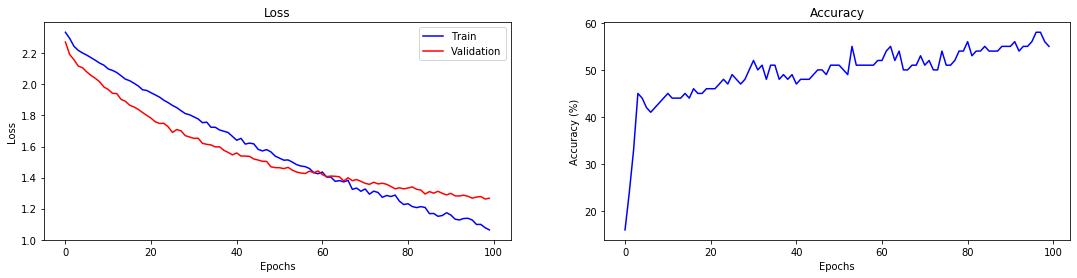


------ NEW EXPERIMENT ------
Dropout = 0.25	Hidden Size = [128, 64, 32, 16]	Learning Rate = 0.0001

Validation set: Average loss: 2.3136, Accuracy: 9/100 (9%)


Validation set: Average loss: 2.3021, Accuracy: 8/100 (8%)


Validation set: Average loss: 2.2931, Accuracy: 12/100 (12%)


Validation set: Average loss: 2.2789, Accuracy: 14/100 (14%)


Validation set: Average loss: 2.261, Accuracy: 16/100 (16%)


Validation set: Average loss: 2.2613, Accuracy: 13/100 (13%)


Validation set: Average loss: 2.244, Accuracy: 15/100 (15%)


Validation set: Average loss: 2.23, Accuracy: 15/100 (15%)


Validation set: Average loss: 2.2146, Accuracy: 19/100 (19%)


Validation set: Average loss: 2.2003, Accuracy: 22/100 (22%)


Validation set: Average loss: 2.1933, Accuracy: 19/100 (19%)


Validation set: Average loss: 2.1849, Accuracy: 16/100 (16%)


Validation set: Average loss: 2.1589, Accuracy: 21/100 (21%)


Validation set: Average loss: 2.1456, Accuracy: 21/100 (21%)


Validation set: Average l

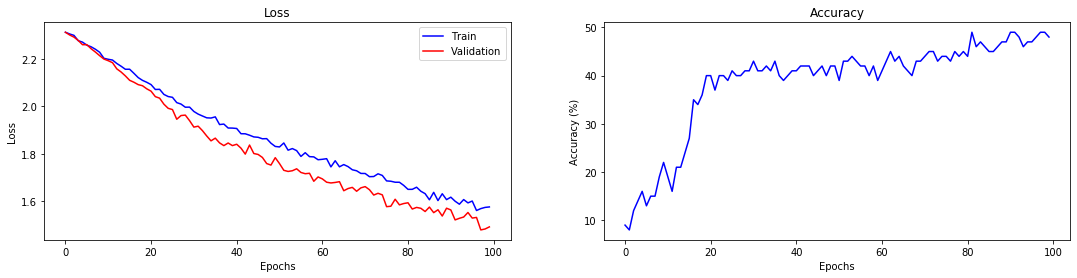


------ NEW EXPERIMENT ------
Dropout = 0.5	Hidden Size = [128, 64, 32, 16]	Learning Rate = 0.0001

Validation set: Average loss: 2.3098, Accuracy: 6/100 (6%)


Validation set: Average loss: 2.2971, Accuracy: 5/100 (5%)


Validation set: Average loss: 2.3008, Accuracy: 8/100 (8%)


Validation set: Average loss: 2.2928, Accuracy: 7/100 (7%)


Validation set: Average loss: 2.2789, Accuracy: 13/100 (13%)


Validation set: Average loss: 2.2742, Accuracy: 13/100 (13%)


Validation set: Average loss: 2.2562, Accuracy: 16/100 (16%)


Validation set: Average loss: 2.2657, Accuracy: 16/100 (16%)


Validation set: Average loss: 2.2593, Accuracy: 17/100 (17%)


Validation set: Average loss: 2.2554, Accuracy: 17/100 (17%)


Validation set: Average loss: 2.246, Accuracy: 17/100 (17%)


Validation set: Average loss: 2.2416, Accuracy: 20/100 (20%)


Validation set: Average loss: 2.2569, Accuracy: 18/100 (18%)


Validation set: Average loss: 2.2231, Accuracy: 24/100 (24%)


Validation set: Average los

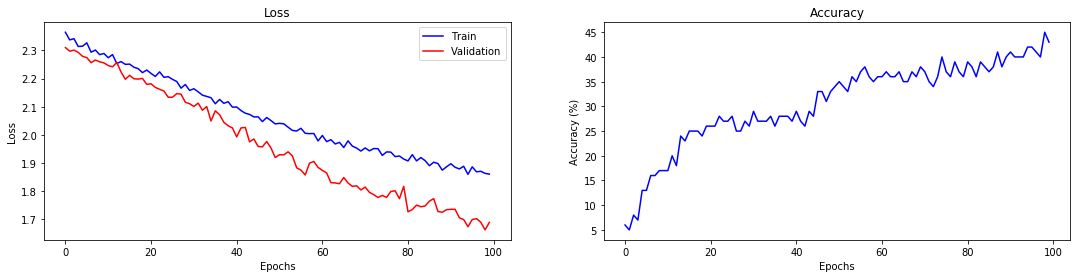


------ NEW EXPERIMENT ------
Dropout = 0.1	Hidden Size = [128, 64, 32, 16]	Learning Rate = 5e-05

Validation set: Average loss: 2.3121, Accuracy: 7/100 (7%)


Validation set: Average loss: 2.297, Accuracy: 14/100 (14%)


Validation set: Average loss: 2.2843, Accuracy: 9/100 (9%)


Validation set: Average loss: 2.2649, Accuracy: 15/100 (15%)


Validation set: Average loss: 2.2513, Accuracy: 15/100 (15%)


Validation set: Average loss: 2.2406, Accuracy: 11/100 (11%)


Validation set: Average loss: 2.2396, Accuracy: 11/100 (11%)


Validation set: Average loss: 2.2276, Accuracy: 12/100 (12%)


Validation set: Average loss: 2.2149, Accuracy: 13/100 (13%)


Validation set: Average loss: 2.1992, Accuracy: 15/100 (15%)


Validation set: Average loss: 2.1882, Accuracy: 17/100 (17%)


Validation set: Average loss: 2.1844, Accuracy: 19/100 (19%)


Validation set: Average loss: 2.1794, Accuracy: 22/100 (22%)


Validation set: Average loss: 2.1584, Accuracy: 25/100 (25%)


Validation set: Average 

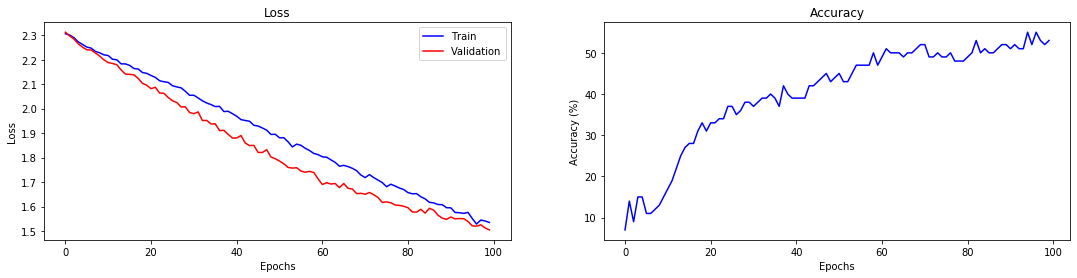


------ NEW EXPERIMENT ------
Dropout = 0.25	Hidden Size = [128, 64, 32, 16]	Learning Rate = 5e-05

Validation set: Average loss: 2.3193, Accuracy: 8/100 (8%)


Validation set: Average loss: 2.302, Accuracy: 12/100 (12%)


Validation set: Average loss: 2.2914, Accuracy: 13/100 (13%)


Validation set: Average loss: 2.2783, Accuracy: 17/100 (17%)


Validation set: Average loss: 2.2599, Accuracy: 21/100 (21%)


Validation set: Average loss: 2.2403, Accuracy: 22/100 (22%)


Validation set: Average loss: 2.2304, Accuracy: 24/100 (24%)


Validation set: Average loss: 2.2213, Accuracy: 25/100 (25%)


Validation set: Average loss: 2.1972, Accuracy: 26/100 (26%)


Validation set: Average loss: 2.1773, Accuracy: 26/100 (26%)


Validation set: Average loss: 2.1556, Accuracy: 25/100 (25%)


Validation set: Average loss: 2.1539, Accuracy: 26/100 (26%)


Validation set: Average loss: 2.1469, Accuracy: 27/100 (27%)


Validation set: Average loss: 2.1131, Accuracy: 27/100 (27%)


Validation set: Avera

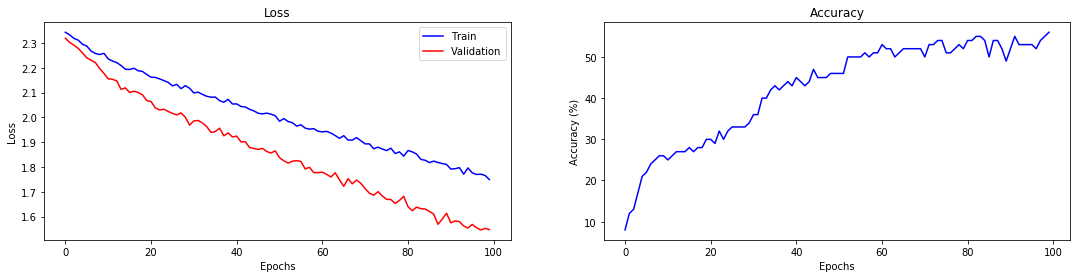


------ NEW EXPERIMENT ------
Dropout = 0.5	Hidden Size = [128, 64, 32, 16]	Learning Rate = 5e-05

Validation set: Average loss: 2.3079, Accuracy: 6/100 (6%)


Validation set: Average loss: 2.3088, Accuracy: 7/100 (7%)


Validation set: Average loss: 2.308, Accuracy: 5/100 (5%)


Validation set: Average loss: 2.3027, Accuracy: 9/100 (9%)


Validation set: Average loss: 2.3012, Accuracy: 9/100 (9%)


Validation set: Average loss: 2.2972, Accuracy: 6/100 (6%)


Validation set: Average loss: 2.2983, Accuracy: 6/100 (6%)


Validation set: Average loss: 2.2923, Accuracy: 6/100 (6%)


Validation set: Average loss: 2.2852, Accuracy: 16/100 (16%)


Validation set: Average loss: 2.2903, Accuracy: 7/100 (7%)


Validation set: Average loss: 2.2898, Accuracy: 6/100 (6%)


Validation set: Average loss: 2.2937, Accuracy: 7/100 (7%)


Validation set: Average loss: 2.2863, Accuracy: 10/100 (10%)


Validation set: Average loss: 2.2878, Accuracy: 10/100 (10%)


Validation set: Average loss: 2.2907, Accu

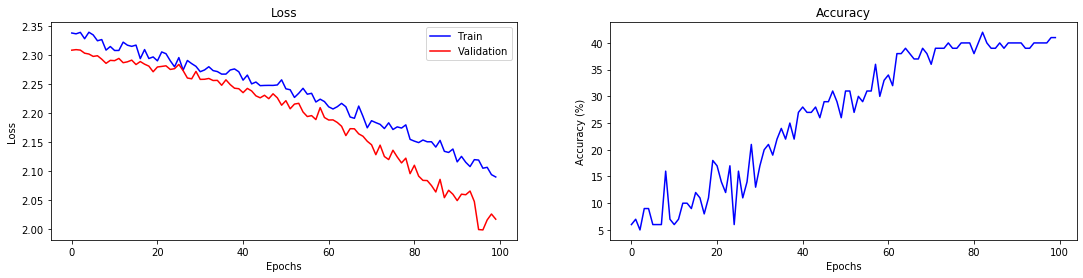

In [15]:
train_data_batches = data_batcher(train_data, train_batch_size)
val_data_batches = data_batcher(val_data, valid_batch_size)

for hidden_size in hidden_size_list:
    for learning_rate in learning_rate_list:
        for dropout in dropout_list:
            print(f'\n------ NEW EXPERIMENT ------\nDropout = {dropout}\tHidden Size = {hidden_size}\tLearning Rate = {learning_rate}')
            model = DNNClassifier(input_size, hidden_size, num_classes, dropout).to(device)

            criterion = nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

            train_losses = []
            valid_losses = []
            accuracies = []

            for epoch in range(num_epochs):
    
                train_loss = train(200, model, device, train_data_batches, optimizer, epoch)
                train_losses.append(train_loss)

                accuracy, valid_loss = validate(model, device, val_data_batches)
                valid_losses.append(valid_loss)
                accuracies.append(accuracy)
            
            plt_curves(train_losses, valid_losses, accuracies)

In [ ]:
#torch.save(model.state_dict(), './results/mgc_dnn_d_bn_fma.model')